# Analyse SEI Parameter Sensitivity Errors wrt Data

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
from mpl_toolkits import mplot3d

eSOH_DIR = "../data/esoh_V/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_sens/"
res_DIR = "../data/results_sens/"

%matplotlib widget

In [2]:
def load_data(cell): 
    cell_no = f'{cell:02d}'
    dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
    dfe_0=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
    dfe['N']=dfe['Time'].astype(int)
    N =dfe.N.unique()
    print("Cycle Numbers:")
    print(*N, sep = ", ") 
    return cell_no,dfe,N

In [3]:
cell = 22
cell_no,dfe,N = load_data_calendar(cell,eSOH_DIR)

Cycle Numbers:
0.0, 25.2705671642907, 93.0685096180532, 130.029355057864, 168.119850242976, 204.058473101817, 245.030302534695


In [4]:
Temp = [25,45,-5]
k_sei = [1,1/1.5,1.5,1/2,2,1/3,3,1/10,10]
# d_sei = [1,1/1.5,1.5,1/2,2,1/3,3,1/10,100]
d_sei = [1,1e-1,1e1,1e-2,1e2,1e-3,1e3,1e-4,1e4]

In [5]:
Temp_idx='0'
ksei_idx='0'
dsei_idx=''
sim_des = 'sens_accl'
T_name = 'T_{0}'.format(Temp_idx)
k_name = 'k_{0}'.format(ksei_idx)
D_name = 'D_{0}'.format(dsei_idx)
dfl = {}
i=0
for file in os.listdir(res_DIR):
    if sim_des in file and ".csv" in file and T_name in file and k_name in file and D_name in file:
        # print(file)
        # ldc_files.append(file)
        dft = pd.read_csv(res_DIR+file,on_bad_lines='skip',low_memory=False)
        dft=dft.reset_index()
        dfl[i]=dft
        i+=1

In [6]:
dfl_m = {}
i=0
for file in os.listdir(res_DIR):
    if sim_des in file and ".csv" in file and T_name in file and k_name in file and D_name in file:
        # print(file)
        # ldc_files.append(file)
        dft = pd.read_csv(res_DIR+file,on_bad_lines='skip',low_memory=False)
        # dft=dft.iloc[::20]
        dft=dft.reset_index()
        # if i>0:
        len_diff = dfe['N'].iloc[-1]-len(dft)+1
        print(len_diff)
        if len_diff>0:
            df_r1 = pd.concat([dft.iloc[[-1]]]*(len_diff), ignore_index=True)
            dft = pd.concat([dft,df_r1], ignore_index=True)
            dft['Cycle number']=np.arange(1,dfe['N'].iloc[-1]+2)
        dfl_m[i]=dft
        i+=1

-3.9696974653049892
-3.9696974653049892
-3.9696974653049892
-3.9696974653049892
-3.9696974653049892
-3.9696974653049892
-3.9696974653049892
-3.9696974653049892
-3.9696974653049892


In [7]:
def plotcomp(all_sumvars_dict0,all_sumvars_dict1):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict0["Cycle number"],all_sumvars_dict0[name],"kx")
        ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"b")
        ax.set_title(split_long_string(name))
        if k ==2 or k==3:
            ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Baseline"] + ["Sim"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [8]:
k_sei_s = [f'{x:0.2f}' for x in k_sei]
d_sei_s = [str(x) for x in d_sei]
Temp_s = [str(x) for x in Temp]

# Plot eSOH vars

In [9]:
# esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]","Local ECM resistance [Ohm]","X-averaged SEI thickness [m]"]
# esoh_vars_str = ["x_100", "y_0", "C_n", "C_p", "cap", "LLI","res","sei"]
# for ev_num in range(len(esoh_vars)):
#     fig, ax = plt.subplots(1,1,figsize=(3,3))
#     col = ['k','g','b','r','c']
#     col_idx = [x // 2 +1 for x in range(-1,8)]
#     mar_idx = [x % 2 for x in range(-1,8)]
#     mar_idx[0]=2
#     mar = [u'v',u'P',u'x']
#     for k in range(len(dfl)):
#         ax.plot(dfl[k]['Cycle number'],dfl[k][esoh_vars[ev_num]],color=col[col_idx[k]],marker=mar[mar_idx[k]])
#         ax.set_title(split_long_string(esoh_vars[ev_num]))
#     # fig.legend(Temp_s, 
#     #            loc="lower center",bbox_to_anchor=[0.5,-0.3], ncol=3, fontsize=11)
#     plt.savefig(fig_DIR+'sens_T_{0}_k_{1}_D_{2}'.format(Temp_idx,ksei_idx,dsei_idx)+'_comp_'+esoh_vars_str[ev_num]+'.png')

In [10]:
sadsada

NameError: name 'sadsada' is not defined

# Calculate RMSE

In [11]:
dfe["Capacity [A.h]"]=dfe["Cap"]
param = pybamm.LithiumIonParameters()
dfe["n_Li"]= 3600/param.F.value*(dfe["y_100"]*dfe["C_p"]+dfe["x_100"]*dfe["C_n"])
dfe["Loss of lithium inventory [%]"]=(1-dfe["n_Li"]/dfe["n_Li"][0])*100

In [12]:
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]#,"Local ECM resistance [Ohm]","X-averaged SEI thickness [m]"]
esoh_vars_str = ["x_100", "y_0", "C_n", "C_p", "cap", "LLI"]#,"res","sei"]
rmse_final = []
rmse_final.append(esoh_vars_str)
for k in range(len(dfl)):
# for ev_num in range(len(esoh_vars)):
    # print([esoh_vars[ev_num]])
    dfl_t = dfl_m[k].iloc[N].reset_index()
    rmse_stats = []
    for ev_num in range(len(esoh_vars)):
    # for k in range(len(dfl)):
        # dfl_t = dfl_m[k].iloc[N].reset_index()
        rmse_t=((dfl_t[esoh_vars[ev_num]] - dfe[esoh_vars[ev_num]]) ** 2).mean() ** .5
        rmse_stats.append(rmse_t)
    print(rmse_stats)
    rmse_final.append(rmse_stats)

[0.016863213328063807, 0.02261253091061523, 0.10347458411957539, 0.1097085683544182, 0.07909846657921851, 1.6645982823270054]
[0.017991053343738295, 0.02172968862835571, 0.1034745858360668, 0.1097085683544182, 0.06926678853792068, 1.0101829598008487]
[0.01687674230393745, 0.02282078646292674, 0.1034745839056656, 0.1097085683544182, 0.08101661577554659, 1.7391976375470388]
[0.0446788523111712, 0.042812727504026864, 0.10347459478552977, 0.1097085683544182, 0.20438186095843996, 3.212836972182808]
[0.016879648919395886, 0.02284294899420843, 0.10347458389789667, 0.1097085683544182, 0.08121769907223181, 1.7467482517909168]
[0.1058346561975262, 0.10492801958041877, 0.10347460693293689, 0.1097085683544182, 0.5488188136263772, 10.424228730710166]
[0.016879955394305736, 0.02284517874411244, 0.10347458389763256, 0.1097085683544182, 0.0812378997376826, 1.7475042238820528]
[0.14600556288832683, 0.14639754027355467, 0.10347461123211456, 0.1097085683544182, 0.7734470479535422, 15.072422600726135]
[0.

In [13]:
x =  rmse_final
wanted = {a[0]: list(a[1:]) for a in zip(*x)}

In [14]:
# wanted

In [15]:
df_1 = pd.DataFrame.from_dict(wanted)
df_1.to_csv(res_DIR+'sens_rmse_T_{0}_k_{1}_D_{2}'.format(Temp_idx,ksei_idx,dsei_idx)+'.csv')

In [16]:
ssdsd

NameError: name 'ssdsd' is not defined

# Plot RMSE 

In [17]:
Temp_idx='0'
ksei_idx='_'
dsei_idx=''
sim_des = 'sens_rmse'
T_name = 'T_{0}'.format(Temp_idx)
k_name = 'k_{0}'.format(ksei_idx)
D_name = 'D_{0}'.format(dsei_idx)
dfl = {}
i=0
for file in os.listdir(res_DIR):
    if sim_des in file and ".csv" in file and T_name in file and k_name in file and D_name in file:
        print(file)
        # ldc_files.append(file)
        dft = pd.read_csv(res_DIR+file,on_bad_lines='skip',low_memory=False)
        dft=dft.reset_index()
        dft=dft.drop(columns=['index','Unnamed: 0'])
        dft['k_sei']=k_sei
        dft['d_sei']=d_sei[i]*np.ones(9)
        dfl[i]=dft
        i+=1

sens_rmse_T_0_k__D_0.csv
sens_rmse_T_0_k__D_1.csv
sens_rmse_T_0_k__D_2.csv
sens_rmse_T_0_k__D_3.csv
sens_rmse_T_0_k__D_4.csv
sens_rmse_T_0_k__D_5.csv
sens_rmse_T_0_k__D_6.csv
sens_rmse_T_0_k__D_7.csv
sens_rmse_T_0_k__D_8.csv


In [18]:
dfc = pd.concat([dfl[0],dfl[1]])
for i in range(2,9):
    dfc=pd.concat([dfc,dfl[i]])
dfc=dfc.reset_index()

In [19]:
dfc.to_csv(res_DIR+'sens_rmse_all'+'.csv')

## Plot eSOH error 3D

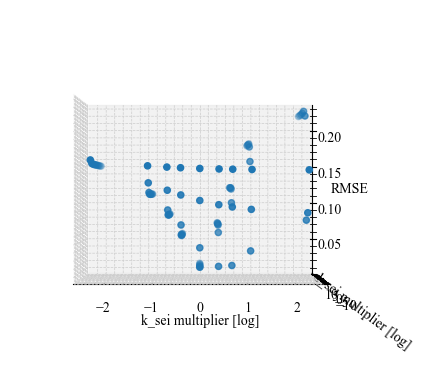

In [20]:
fig = plt.figure()
ax = plt.axes(projection='3d')

X,Y = np.meshgrid(dfc['k_sei'],dfc['d_sei'])

ax.scatter3D(np.log(dfc['k_sei']),np.log(dfc['d_sei']),dfc['x_100'])
ax.set_xlabel('k_sei multiplier [log]')
ax.set_ylabel('d_sei multiplier [log]')
ax.set_zlabel('RMSE')
ax.view_init(0,-90)

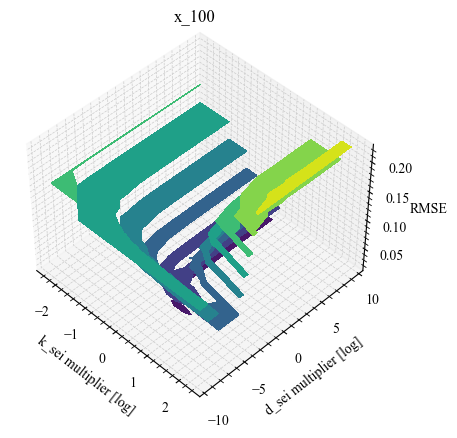

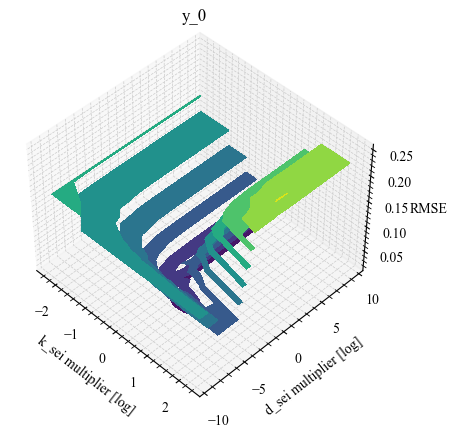

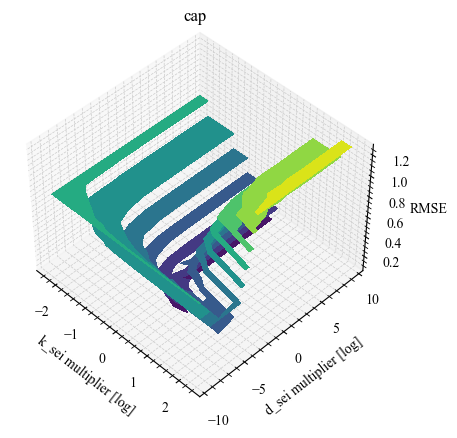

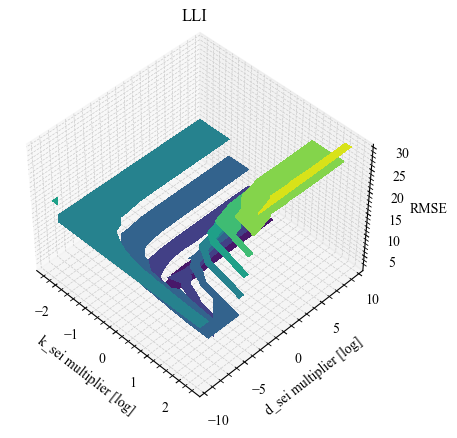

In [21]:
esoh_vars_str = ["x_100", "y_0", "cap", "LLI"]
ii = 0
for ii in range(len(esoh_vars_str)):
    ii
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    # ax.contour3D(X, Y, Z, 50, cmap='binary')
    ax.tricontourf(np.log(dfc['k_sei']),np.log(dfc['d_sei']),dfc[esoh_vars_str[ii]])
    ax.set_xlabel('k_sei multiplier [log]')
    ax.set_ylabel('d_sei multiplier [log]')
    ax.set_zlabel('RMSE')
    ax.set_title(esoh_vars_str[ii])
    ax.view_init(45,-45)
    # ax.view_init(0,-90)
    plt.savefig(fig_DIR+'sens_rmse_cont_{0}'.format(esoh_vars_str[ii])+'.png')


## Plot eSOH 2D

In [22]:
kk=0
# dfl[kk]

In [23]:
# esoh_vars_str = ["x_100", "y_0", "C_n", "C_p", "cap", "LLI"]#,"res","sei"]
# for ev_num in range(len(esoh_vars_str)):
#     fig, ax = plt.subplots(1,1,figsize=(3,3))

#     ax.scatter(d_sei,dfl[kk][esoh_vars_str[ev_num]])
#     ax.set_title(split_long_string(esoh_vars[ev_num]))
#     ax.set_xscale('log')
#     # fig.legend(Temp_s, 
#     #            loc="lower center",bbox_to_anchor=[0.5,-0.3], ncol=3, fontsize=11)
#     plt.savefig(fig_DIR+'sens_T_{0}_k_{1}_D_{2}'.format(Temp_idx,ksei_idx,dsei_idx)+'_comp_'+esoh_vars_str[ev_num]+'_rmse.png')